<a href="https://colab.research.google.com/github/Salsabilaurelia1408/tugasakhirsalsa/blob/main/WGPR_Kode_Bang_Tita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers import LSTM, GRU, SimpleRNN
from keras.utils import plot_model

In [ ]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [ ]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

            Date    WOPR  WWPR   WGPR  GOR   WBHP
Time                                             
5     2015-07-06  1314.0   0.0  0.240  183  323.0
6     2015-07-07  1321.0   0.0  0.260  197  335.0
7     2015-07-08  1309.0   0.0  0.247  189  343.0
8     2015-07-09  1299.0   0.0  0.233  179  348.0
9     2015-07-10  1287.0   0.0  0.240  186  349.0
...          ...     ...   ...    ...  ...    ...
686   2017-05-17   501.2  13.1  0.315  628  239.0
687   2017-05-18   501.3  12.4  0.313  624  240.0
688   2017-05-19   500.2  12.5  0.314  628  239.0
689   2017-05-20   503.1  11.5  0.311  618  241.0
690   2017-05-21   503.1  11.5  0.311  618  241.0

[629 rows x 6 columns]


<Axes: xlabel='Time'>

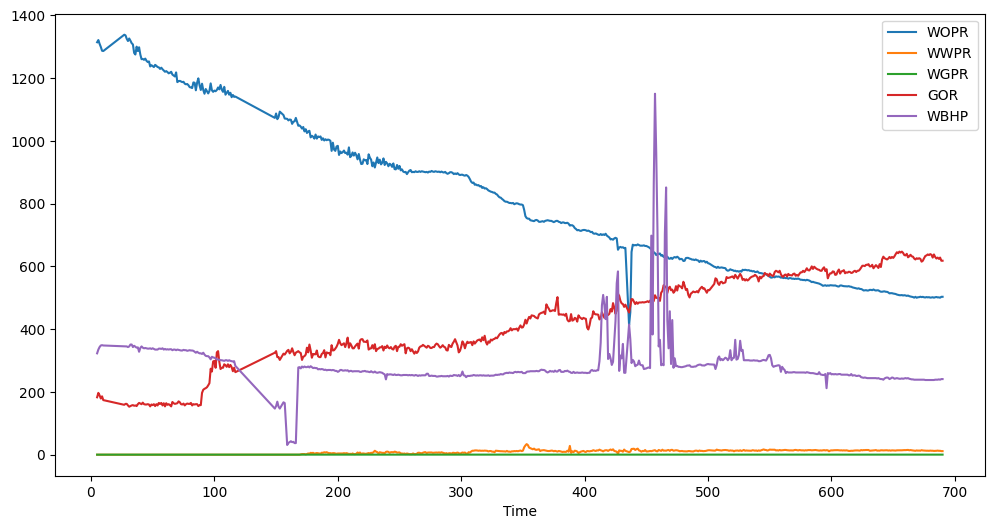

In [ ]:
# Load data
url ='https://raw.githubusercontent.com/Salsabilaurelia1408/tugasakhirsalsa/main/WOPR2_DateFormatRevised.csv'

df = pd.read_csv(url, index_col='Time', parse_dates=True)
'''
df.set_index('Date', inplace=True)
df.index.freq ='MS'
'''

print(df)

df.plot(figsize=(12,6))

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def load_data(filename):
    """
    This function reads csv file from the given url and extracts time-series data of oil & water rate,
    pressure, and water cut.
    :param filename: the url of csv file (stored in GitHub)
    :return: t: vector of time; qo: matrix of oil rate in all wells; qo: matrix of water rate in all wells;
            and p: matrix of bottom hole pressure in all wells
    """
    df = pd.read_csv(filename)

    t = df.loc[:, ['Time']] # Time in simulation: DAY
    t *= 24 # Converting time from DAY to HOUR
    qo = df.loc[:, ['WOPR']]
    qw = df.loc[:, ['WWPR']]
    p = df.loc[:, ['WBHP']]
    qg = df.loc[:, ['WGPR']]
    return t, qo, qw, qg, p

def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', lw=3, title='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', mec='red', title='Training Set', lw=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', mec='orange', title='Dev Set', lw=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', mec='green', title='Test Set', lw=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', lw=3, )
    plt.title('Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', mec ='red', lw=3)
    plt.title('Training Set')

    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', mec ='orange', lw=3)
    plt.title('Dev Set')

    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', mec ='green', lw =3)    
    plt.title('Test Set')
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate Gas(MMSCF)", fontsize=14)
    plt.title("Flow Rate Gas " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0.3, max(max(q_actual), max(q_pred)) + 0.02)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):
    """This function plots actual flow rates"""
    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
    """This function plots both pressure and actual flow rates"""
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['Time'], x['WWPR'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['Time'], x['WOPR'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0.3, max(max(x['WWPR:P1'].values), max(x['WOPR:P1'].values)) + 0.1)

'''
    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR:P2'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P2'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P2'].values), max(x['WOPR:P2'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR:P3'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P3'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P3'].values), max(x['WOPR:P3'].values)) + 10)
'''

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
t, qo, qw, qg, p = load_data('https://raw.githubusercontent.com/Salsabilaurelia1408/tugasakhirsalsa/main/WOPR2_DateFormatRevised.csv')

In [ ]:
# Group the input
X_raw = p
Y_raw = qg

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)


# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train_raw)
x_dev_scaled = scaler.fit_transform(x_dev_raw)
x_test_scaled = scaler.fit_transform(x_test_raw)

y_train_scaled = scaler.fit_transform(np.array(y_train_raw).reshape(-1,1))
y_dev_scaled = scaler.fit_transform(np.array(y_dev_raw).reshape(-1,1))
y_test_scaled = scaler.fit_transform(np.array(y_test_raw).reshape(-1,1))

x_train, y_train = create_timeblock(x_train_scaled, y_train_scaled, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_scaled, y_dev_scaled, look_back=25)
x_test, y_test = create_timeblock(x_test_scaled, y_test_scaled, look_back=25)
'''
# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.values)
x_dev_norm = scaler_x.transform(x_dev_raw.values)
x_test_norm = scaler_x.transform(x_test_raw.values)

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.values)
y_dev_norm = scaler_y.transform(y_dev_raw.values)
y_test_norm = scaler_y.transform(y_test_raw.values)

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)
'''

# of data:  414
# of data:  70
# of data:  70


'\n# Data Scaling\nscaler_x = MinMaxScaler()\nx_train_norm = scaler_x.fit_transform(x_train_raw.values)\nx_dev_norm = scaler_x.transform(x_dev_raw.values)\nx_test_norm = scaler_x.transform(x_test_raw.values)\n\nscaler_y = MinMaxScaler()\ny_train_norm = scaler_y.fit_transform(y_train_raw.values)\ny_dev_norm = scaler_y.transform(y_dev_raw.values)\ny_test_norm = scaler_y.transform(y_test_raw.values)\n\n# Create time blocks\nx_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)\nx_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)\nx_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)\n'

In [ ]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}


    inputs = Input(shape = (x_train.shape[1], x_train.shape[2]))

    X = classifier[method](128, return_sequences=True)(inputs)
    X = classifier[method](256, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(128, activation='relu'))(X)
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    '''
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    '''
    model = Model(inputs=inputs, outputs=out1)

    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, y_train[:,0], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, y_dev[:,0]), 
                        verbose=1, shuffle=False)
    return model, history

In [ ]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='LSTM')

Epoch 1/300
2/2 [==============================] - 7s 2s/step - loss: 0.3845 - mae: 0.5839 - accuracy: 0.0024 - val_loss: 0.0934 - val_mae: 0.2500 - val_accuracy: 0.0143
Epoch 2/300
2/2 [==============================] - 2s 589ms/step - loss: 0.1972 - mae: 0.4105 - accuracy: 0.0024 - val_loss: 0.3672 - val_mae: 0.5285 - val_accuracy: 0.0286
Epoch 3/300
2/2 [==============================] - 1s 336ms/step - loss: 0.1184 - mae: 0.2358 - accuracy: 0.0024 - val_loss: 0.2701 - val_mae: 0.4524 - val_accuracy: 0.0286
Epoch 4/300
2/2 [==============================] - 1s 324ms/step - loss: 0.0721 - mae: 0.1714 - accuracy: 0.0024 - val_loss: 0.0542 - val_mae: 0.1927 - val_accuracy: 0.0286
Epoch 5/300
2/2 [==============================] - 1s 329ms/step - loss: 0.0947 - mae: 0.2922 - accuracy: 0.0024 - val_loss: 0.0439 - val_mae: 0.1739 - val_accuracy: 0.0286
Epoch 6/300
2/2 [==============================] - 1s 333ms/step - loss: 0.0987 - mae: 0.2987 - accuracy: 0.0024 - val_loss: 0.0614 - val_

In [ ]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
'y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)'
y_pred_train_LSTM = scaler.inverse_transform(y_pred_train_pre.reshape(-1,1))
y_train_act = scaler.inverse_transform(y_train.reshape(-1,1))

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
'y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)'
y_pred_dev_LSTM = scaler.inverse_transform(y_pred_dev_pre.reshape(-1,1))
y_dev_act = scaler.inverse_transform(y_dev.reshape(-1,1))

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
'y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)'
y_pred_test_LSTM = scaler.inverse_transform(y_pred_test_pre.reshape(-1,1))
y_test_act = scaler.inverse_transform(y_test.reshape(-1,1))

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train_LSTM, y_pred_dev_LSTM, y_pred_test_LSTM])

3/3 [==============================] - 0s 28ms/step


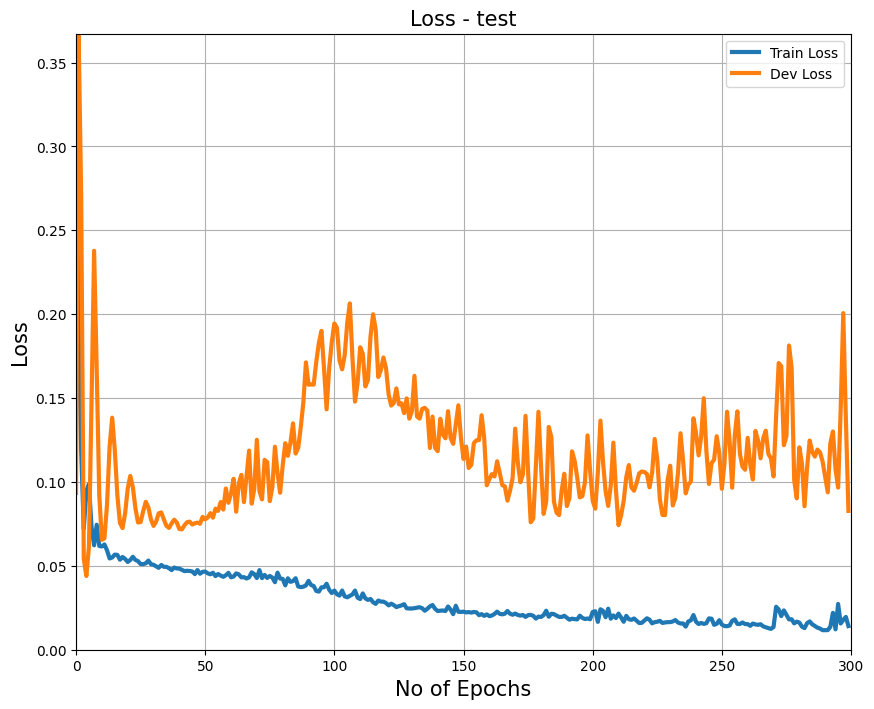

Training Set Score: 0.6591
Dev Set Score: -0.7148
Test Set Score: -2.1671
Training Set MSE: 0.0000
Dev Set MSE: 0.0001
Test Set MSE: 0.0001


In [ ]:
plot_loss(history_LSTM, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train_LSTM), r2_score(y_train_act, y_pred_train_LSTM)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev_LSTM), r2_score(y_dev_act, y_pred_dev_LSTM)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test_LSTM), r2_score(y_test_act, y_pred_test_LSTM)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

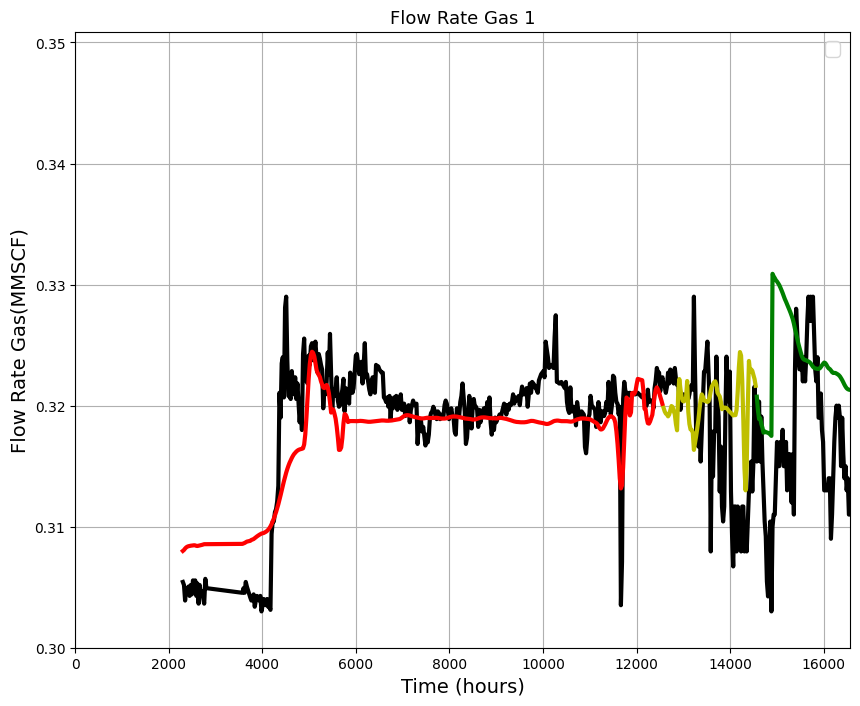

In [ ]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].values,
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))


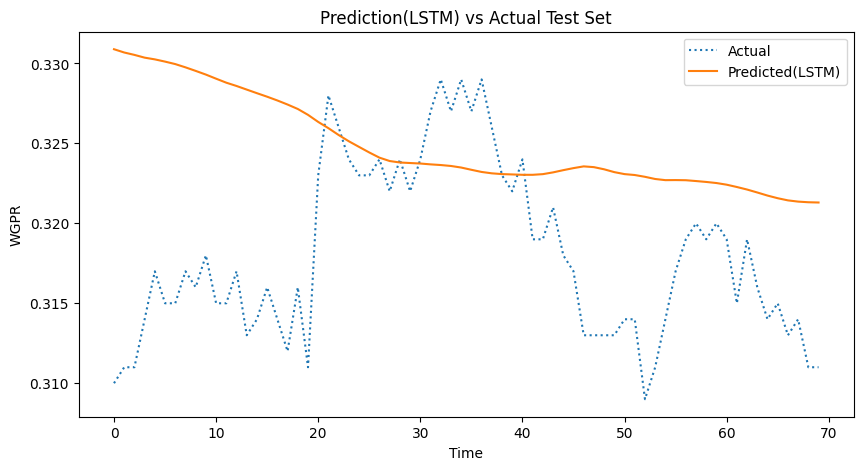

In [ ]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_act, label='Actual', ls ='dotted')
plt.plot(y_pred_test_LSTM, label='Predicted(LSTM)')
plt.title('Prediction(LSTM) vs Actual Test Set')
plt.xlabel('Time')
plt.ylabel('WGPR')
plt.legend()
plt.show()

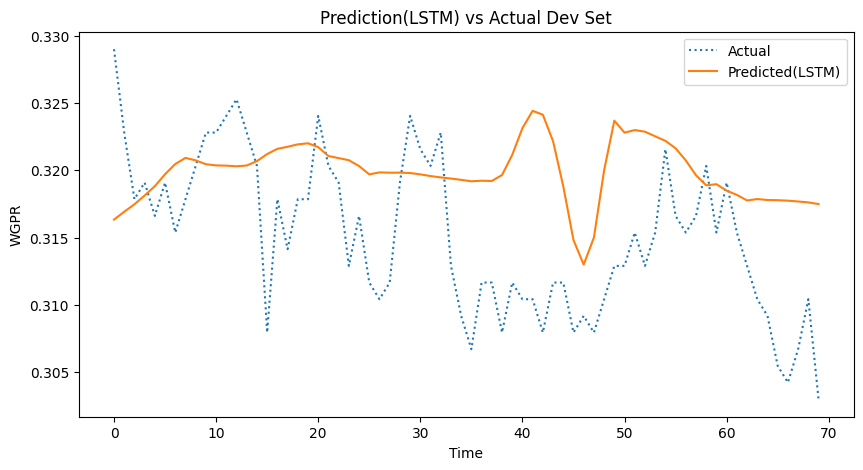

In [ ]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_dev_act, label='Actual', ls ='dotted')
plt.plot(y_pred_dev_LSTM, label='Predicted(LSTM)')
plt.title('Prediction(LSTM) vs Actual Dev Set')
plt.xlabel('Time')
plt.ylabel('WGPR')
plt.legend()
plt.show()

Epoch 1/300
2/2 [==============================] - 7s 1s/step - loss: 0.3938 - mae: 0.5919 - accuracy: 0.0024 - val_loss: 0.0934 - val_mae: 0.2520 - val_accuracy: 0.0143
Epoch 2/300
2/2 [==============================] - 1s 274ms/step - loss: 0.1982 - mae: 0.4156 - accuracy: 0.0024 - val_loss: 0.1476 - val_mae: 0.3336 - val_accuracy: 0.0286
Epoch 3/300
2/2 [==============================] - 1s 270ms/step - loss: 0.1019 - mae: 0.2504 - accuracy: 0.0024 - val_loss: 0.4083 - val_mae: 0.5657 - val_accuracy: 0.0286
Epoch 4/300
2/2 [==============================] - 1s 273ms/step - loss: 0.0992 - mae: 0.1911 - accuracy: 0.0024 - val_loss: 0.1010 - val_mae: 0.2728 - val_accuracy: 0.0286
Epoch 5/300
2/2 [==============================] - 1s 257ms/step - loss: 0.0709 - mae: 0.2233 - accuracy: 0.0024 - val_loss: 0.0454 - val_mae: 0.1779 - val_accuracy: 0.0286
Epoch 6/300
2/2 [==============================] - 1s 271ms/step - loss: 0.0918 - mae: 0.2863 - accuracy: 0.0024 - val_loss: 0.0442 - val_

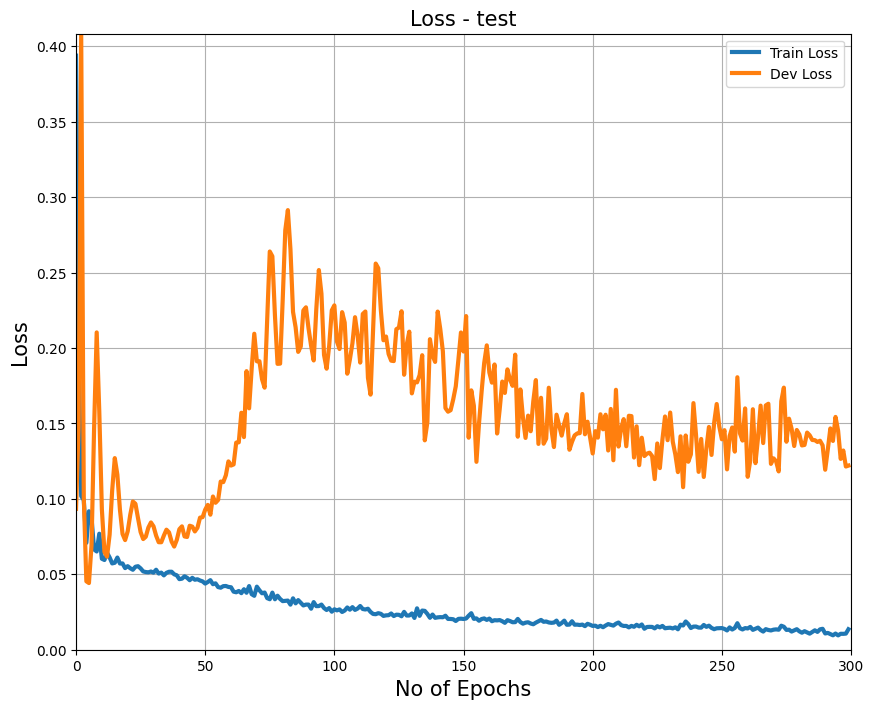

Training Set Score: 0.7595
Dev Set Score: -1.5286
Test Set Score: -2.7354
Training Set MSE: 0.0000
Dev Set MSE: 0.0001
Test Set MSE: 0.0001


In [ ]:
model_GRU, history_GRU = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='GRU')

# Training
y_pred_train_pre = model_GRU.predict(x_train)
'y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)'
y_pred_train_GRU = scaler.inverse_transform(y_pred_train_pre.reshape(-1,1))
y_train_act = scaler.inverse_transform(y_train.reshape(-1,1))

# Dev
y_pred_dev_pre = model_GRU.predict(x_dev)
'y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)'
y_pred_dev_GRU = scaler.inverse_transform(y_pred_dev_pre.reshape(-1,1))
y_dev_act = scaler.inverse_transform(y_dev.reshape(-1,1))

# Test7
y_pred_test_pre = model_GRU.predict(x_test)
'y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)'
y_pred_test_GRU = scaler.inverse_transform(y_pred_test_pre.reshape(-1,1))
y_test_act = scaler.inverse_transform(y_test.reshape(-1,1))

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train_GRU, y_pred_dev_GRU, y_pred_test_GRU])

plot_loss(history_GRU, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train_GRU), r2_score(y_train_act, y_pred_train_GRU)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev_GRU), r2_score(y_dev_act, y_pred_dev_GRU)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test_GRU), r2_score(y_test_act, y_pred_test_GRU)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)



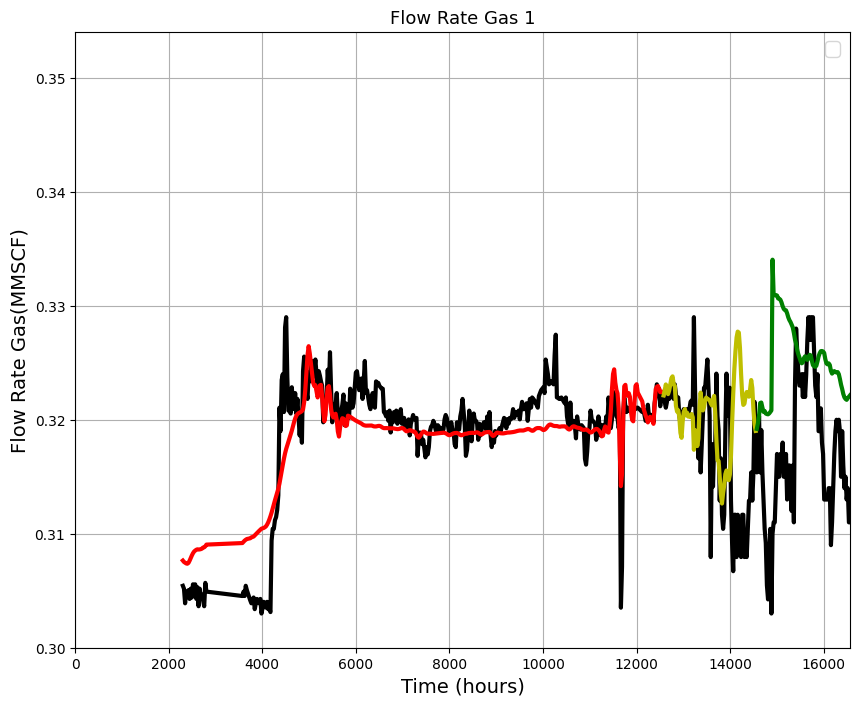

In [ ]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].to_numpy(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

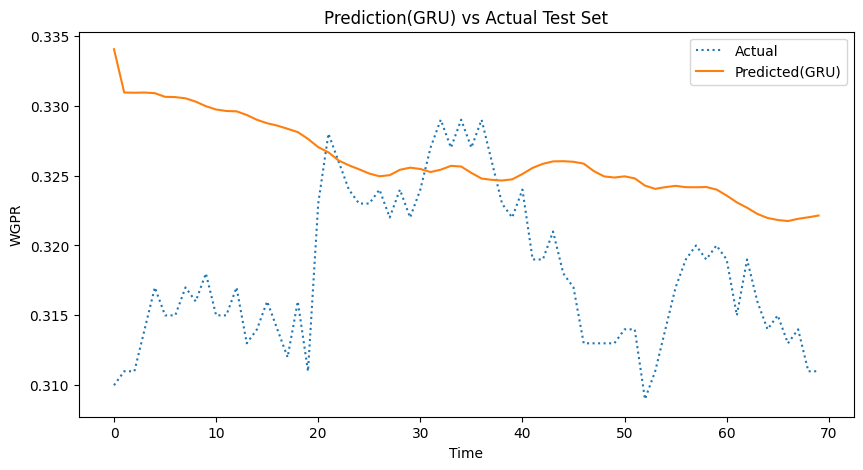

In [ ]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_act, label='Actual', ls ='dotted')
plt.plot(y_pred_test_GRU, label='Predicted(GRU)')
plt.title('Prediction(GRU) vs Actual Test Set')
plt.xlabel('Time')
plt.ylabel('WGPR')
plt.legend()
plt.show()

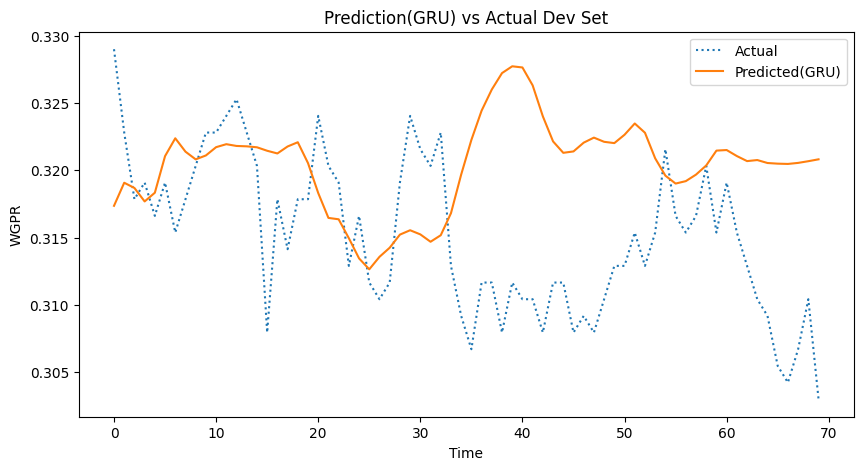

In [ ]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_dev_act, label='Actual', ls ='dotted')
plt.plot(y_pred_dev_GRU, label='Predicted(GRU)')
plt.title('Prediction(GRU) vs Actual Dev Set')
plt.xlabel('Time')
plt.ylabel('WGPR')
plt.legend()
plt.show()

Epoch 1/300
2/2 [==============================] - 3s 476ms/step - loss: 0.7950 - mae: 0.6881 - accuracy: 0.0024 - val_loss: 0.0536 - val_mae: 0.1930 - val_accuracy: 0.0143
Epoch 2/300
2/2 [==============================] - 0s 176ms/step - loss: 0.2329 - mae: 0.4256 - accuracy: 0.0024 - val_loss: 0.1334 - val_mae: 0.3023 - val_accuracy: 0.0286
Epoch 3/300
2/2 [==============================] - 0s 138ms/step - loss: 0.1254 - mae: 0.2628 - accuracy: 0.0048 - val_loss: 0.0700 - val_mae: 0.2148 - val_accuracy: 0.0286
Epoch 4/300
2/2 [==============================] - 0s 132ms/step - loss: 0.0996 - mae: 0.2462 - accuracy: 0.0000e+00 - val_loss: 0.0655 - val_mae: 0.2108 - val_accuracy: 0.0286
Epoch 5/300
2/2 [==============================] - 0s 126ms/step - loss: 0.0839 - mae: 0.2230 - accuracy: 0.0024 - val_loss: 0.1106 - val_mae: 0.2781 - val_accuracy: 0.0286
Epoch 6/300
2/2 [==============================] - 0s 134ms/step - loss: 0.1119 - mae: 0.2464 - accuracy: 0.0024 - val_loss: 0.0432

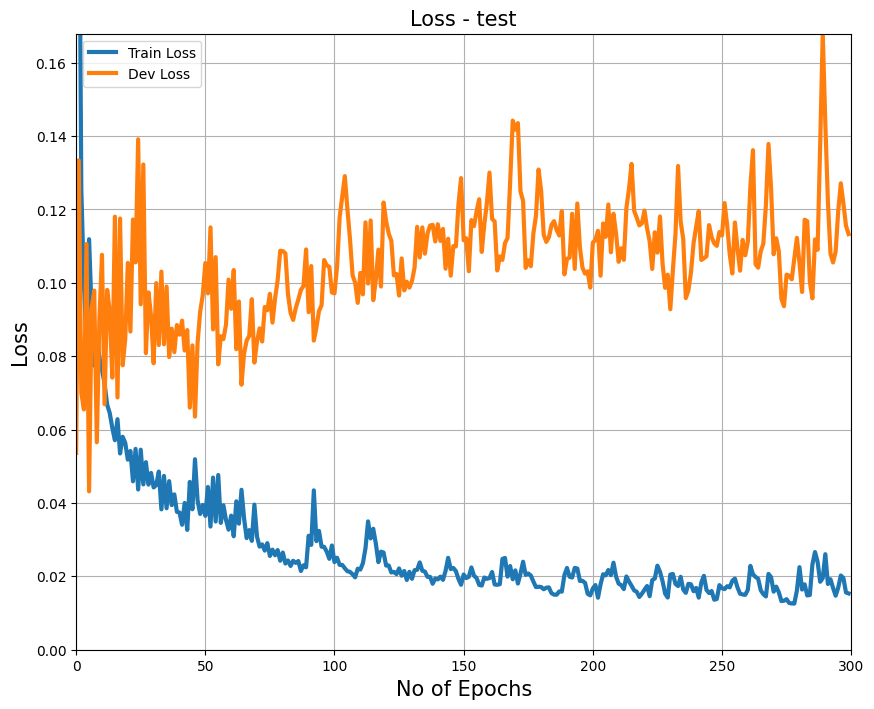

Training Set Score: 0.6535
Dev Set Score: -1.3473
Test Set Score: -1.3971
Training Set MSE: 0.0000
Dev Set MSE: 0.0001
Test Set MSE: 0.0001


In [ ]:
import time
start_time = time.time()
model_RNN, history_RNN = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='Simple RNN')
# Measure running time
print("Completed in %s seconds" % (time.time() - start_time))

# Training
y_pred_train_pre = model_RNN.predict(x_train)
'y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)'
y_pred_train_RNN = scaler.inverse_transform(y_pred_train_pre.reshape(-1,1))
y_train_act = scaler.inverse_transform(y_train.reshape(-1,1))

# Dev
y_pred_dev_pre = model_RNN.predict(x_dev)
'y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)'
y_pred_dev_RNN = scaler.inverse_transform(y_pred_dev_pre.reshape(-1,1))
y_dev_act = scaler.inverse_transform(y_dev.reshape(-1,1))

# Test
y_pred_test_pre = model_RNN.predict(x_test)
'y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)'
y_pred_test_RNN = scaler.inverse_transform(y_pred_test_pre.reshape(-1,1))
y_test_act = scaler.inverse_transform(y_test.reshape(-1,1))

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train_RNN, y_pred_dev_RNN, y_pred_test_RNN])

plot_loss(history_RNN, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train_RNN), r2_score(y_train_act, y_pred_train_RNN)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev_RNN), r2_score(y_dev_act, y_pred_dev_RNN)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test_RNN), r2_score(y_test_act, y_pred_test_RNN)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)



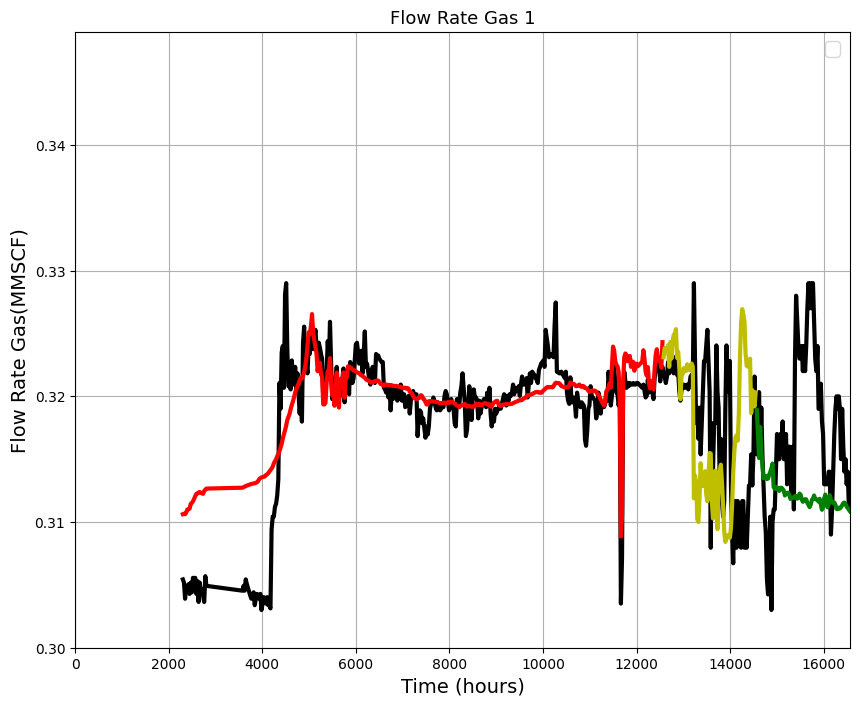

In [ ]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].values,
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

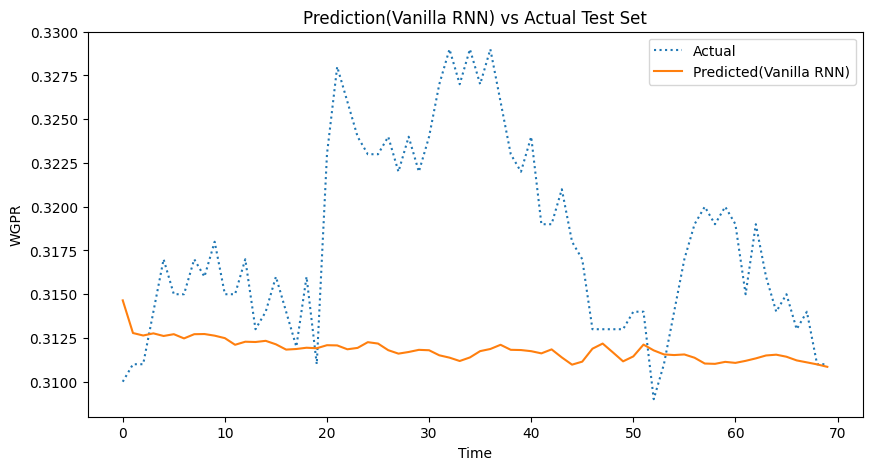

In [ ]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_act, label='Actual', ls ='dotted')
plt.plot(y_pred_test_RNN, label='Predicted(Vanilla RNN)')
plt.title('Prediction(Vanilla RNN) vs Actual Test Set')
plt.xlabel('Time')
plt.ylabel('WGPR')
plt.legend()
plt.show()

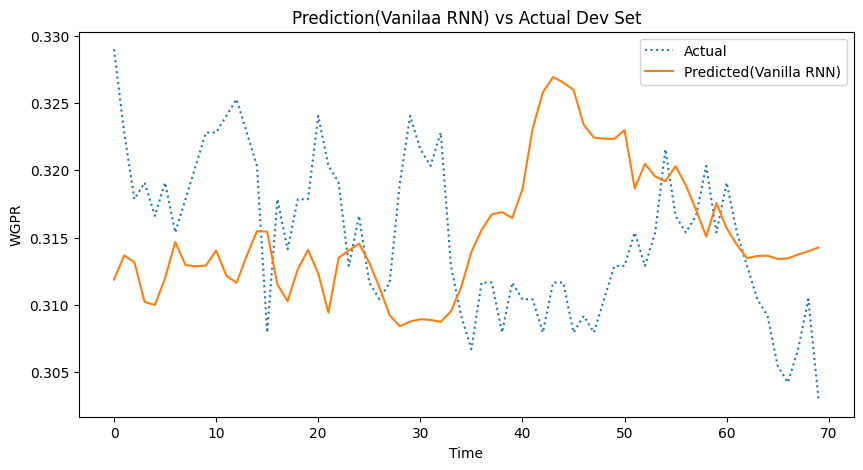

In [ ]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_dev_act, label='Actual', ls ='dotted')
plt.plot(y_pred_dev_RNN, label='Predicted(Vanilla RNN)')
plt.title('Prediction(Vanilaa RNN) vs Actual Dev Set')
plt.xlabel('Time')
plt.ylabel('WGPR')
plt.legend()
plt.show()